# **DATA PREPARATION**

## Download and unzip data from Kaggle

In [7]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c new-york-city-taxi-fare-prediction
! mkdir train
! unzip train.csv.zip -d train

mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/960k [00:00<?, ?B/s]
100% 960k/960k [00:00<00:00, 62.9MB/s]
  0% 0.00/335k [00:00<?, ?B/s]
100% 335k/335k [00:00<00:00, 108MB/s]
 99% 1.55G/1.56G [00:14<00:00, 113MB/s]
100% 1.56G/1.56G [00:14<00:00, 115MB/s]
  0% 0.00/486 [00:00<?, ?B/s]
100% 486/486 [00:00<00:00, 477kB/s]
mkdir: cannot create directory ‘train’: File exists
Archive:  train.csv.zip
  inflating: train/train.csv         


## Import data loading libraries

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
%matplotlib inline

# from pydoc import help
# from scipy.stats.stats import pearsonr

# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.svm import SVR
# from xgboost.sklearn import XGBRegressor

from sklearn.metrics import mean_squared_error

# from sklearn.model_selection import cross_val_score, cross_val_predict
# from sklearn import metrics
# import datetime
from datetime import timedelta
import datetime as dt
import calendar

# import math

### Load 10% of total train data (55M) = 5.5M

In [9]:
train = pd.read_csv('./train/train.csv', nrows = 5500000, parse_dates=["pickup_datetime"])
test =  pd.read_csv('./test.csv', parse_dates=["pickup_datetime"])

## Data cleaning


*   Checking for missing values and removing the rows corresponding to them if any.

In [10]:
train = train.dropna(how='any', axis='rows')

*   Removing the rows that have -ve values of Fare amount as Fare cannot be -ve.

In [11]:
train = train.loc[train['fare_amount']>=0]

* Truncate longitude and latitude coordinates based on NY

> NewYork City coordinates are https://www.travelmath.com/cities/New+York,+NY
> Here, we will try to define bounding box of interest by [long_min, long_max, latt_min, latt_max] using the minimum and maximum coordinates from test.csv. 
This will help us to make sure to train a model for the full pickup/dropoff co-ordinate range for the test set.

In [12]:
def get_bb_coords(df, b_box):
  """function to select bounding box coordinates"""
  return ((df["pickup_longitude"] >= b_box[0]) & (df["pickup_longitude"] <= b_box[1]) & 
          (df["pickup_latitude"] >= b_box[2]) & (df["pickup_latitude"] <= b_box[3]) &
          (df["dropoff_longitude"] >= b_box[0]) & (df["dropoff_longitude"] <= b_box[1]) &
          (df["dropoff_latitude"] >= b_box[2]) & (df["dropoff_latitude"] <= b_box[3]))

* Minimum and Maximum Longitude Test set

In [13]:
print("Longitude:")
print("Minimum")
print(min(test["pickup_longitude"].min(), test["dropoff_longitude"].min()))
print("Maximum")
print(max(test["pickup_longitude"].max(), test["dropoff_longitude"].max()))

Longitude:
Minimum
-74.263242
Maximum
-72.986532


* Minimum and Maximum Longitude Train set

In [14]:
print("Longitude:")
print("Minimum")
print(min(train["pickup_longitude"].min(), train["dropoff_longitude"].min()))
print("Maximum")
print(max(train["pickup_longitude"].max(), train["dropoff_longitude"].max()))

Longitude:
Minimum
-3426.60895
Maximum
3457.62235


* Minimum and Maximum Latitude Test set

In [15]:
print("Latitude:")
print("Minimum")
print(min(test["pickup_latitude"].min(), test["dropoff_latitude"].min()))
print("Maximum")
print(max(test["pickup_latitude"].max(), test["dropoff_latitude"].max()))

Latitude:
Minimum
40.568973
Maximum
41.709555


* Minimum and Maximum Latitude Train set

In [16]:
print("Latitude:")
print("Minimum")
print(min(train["pickup_latitude"].min(), train["dropoff_latitude"].min()))
print("Maximum")
print(max(train["pickup_latitude"].max(), train["dropoff_latitude"].max()))

Latitude:
Minimum
-3488.079513
Maximum
3345.9173530000003


In [17]:
bounding_box = (-74.3, -73.0, 40.6, 41.7)

In [18]:
train = train[get_bb_coords(train, bounding_box)]

In [19]:
print("New size {}".format(len(train)))

New size 5377880


* Formula to be used for calculating the distance between latitude and longitude

In [20]:
def calc_haversian_dist(lat1, lat2, lon1,lon2):
  """HAVERSIAN DISTANCE"""
  p = 0.017453292519943295 # Pi/180
  a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
  return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

In [21]:
train['distance_miles'] = train.apply(lambda row:calc_haversian_dist(
                                                    row['pickup_latitude'],
                                                    row['dropoff_latitude'],
                                                    row['pickup_longitude'],
                                                    row['dropoff_longitude']), axis=1)
test['distance_miles'] = test.apply(lambda row:calc_haversian_dist(
                                                    row['pickup_latitude'],
                                                    row['dropoff_latitude'],
                                                    row['pickup_longitude'],
                                                    row['dropoff_longitude']), axis=1)

* Initialize NYC Latitude and Longitudes

Source: https://www.latlong.net/place/new-york-city-ny-usa-1848.html

In [22]:
nyc = (40.730610, -73.935242)

## Extract data from PICKUP_DATETIME feature in the dataset 

In [24]:
train['year'] = train["pickup_datetime"].apply(lambda t: t.year)
test['year'] = test["pickup_datetime"].apply(lambda t: t.year)

train['weekday'] = train["pickup_datetime"].apply(lambda t: t.weekday())
test['weekday'] = test["pickup_datetime"].apply(lambda t: t.weekday())

train['hour'] = train["pickup_datetime"].apply(lambda t: t.hour)
test['hour'] = test["pickup_datetime"].apply(lambda t: t.hour)

### Formula to be used for calculating the distance between latitude and longitude

In [25]:
def distance(lat1, lon1, lat2, lon2):
  p = 0.017453292519943295 # Pi/180
  a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p))/2
  return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

#### The longer the distance between pickup and dropoff location, higher the fare. Adding new column to dataframe with distance in miles

In [26]:
train["distance_miles"] = distance(train["pickup_latitude"], train["pickup_longitude"], 
                                      train["dropoff_latitude"], train["dropoff_longitude"])
test["distance_miles"] = distance(test["pickup_latitude"], test["pickup_longitude"], 
                                      test["dropoff_latitude"], test["dropoff_longitude"])

* Let us visualize distance in miles in histogram

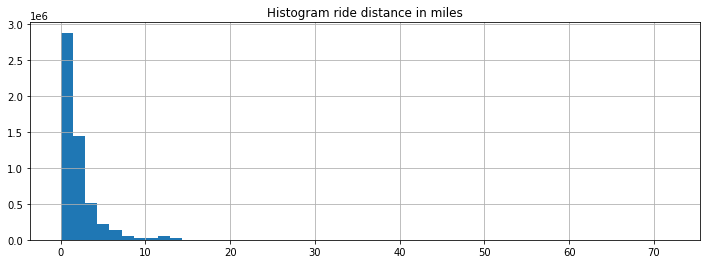

In [27]:
train["distance_miles"].hist(bins=50, figsize=(12,4))
plt.title("Histogram ride distance in miles");

In [28]:
train["distance_miles"].describe()

count    5.377880e+06
mean     2.060835e+00
std      2.326754e+00
min      0.000000e+00
25%      7.785930e-01
50%      1.336245e+00
75%      2.425571e+00
max      7.182827e+01
Name: distance_miles, dtype: float64

* Most rides are just short rides

* Let us plot distance miles, fare amount and passenger count

In [29]:
train.groupby('passenger_count')['distance_miles','fare_amount'].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,distance_miles,fare_amount
passenger_count,,
0,1.761221,8.939972
1,2.031045,11.162573
2,2.174221,11.774501
3,2.101630,11.520936
4,2.135483,11.730346
5,2.067444,11.180221
6,2.110862,12.117871
7,1.008573,8.500000
9,6.989698,70.520000


#### Scatter plot Distance vs Fare

Text(0.5, 1.0, 'Distance and fare < $100')

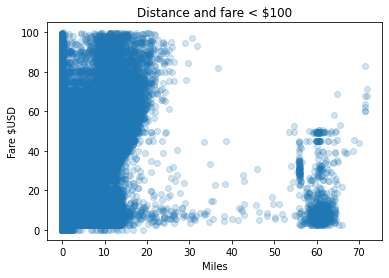

In [30]:
idx = ((train['distance_miles'] < 100) & (train["fare_amount"] < 100))
plt.scatter(train[idx]["distance_miles"], train[idx]["fare_amount"], alpha=0.2)
plt.xlabel("Miles")
plt.ylabel("Fare $USD")
plt.title("Distance and fare < $100")

**Few Obervations -**
1. Trips with zero distance but with non-zero fare. May be due to cancelled trips.
2. Few trips with >= 50 miles travel but low fare. May be due to discounted trips.

### We can use add direction for calculation of fare amount



In [31]:
train["delta_lon"] = train["pickup_longitude"] - train["dropoff_longitude"]
test["delta_lon"] = test["pickup_longitude"] - test["dropoff_longitude"]

train["delta_lat"] = train["pickup_latitude"] - train["dropoff_latitude"]
test["delta_lat"] = test["pickup_latitude"] - test["dropoff_latitude"]

In [32]:
def find_dir(lon, lat):
  """Using direction finding algorithm"""
  result = np.zeros(len(lon))
  l = np.sqrt(lon**2 + lat**2)
  result[lon>0] = (180/np.pi)*np.arcsin(lat[lon>0]/l[lon>0])
  idx = (lon<0) & (lat>0)
  result[idx] = 180 - (180/np.pi)*np.arcsin(lat[idx]/l[idx])
  idx = (lon<0) & (lat<0)
  result[idx] = -180 - (180/np.pi)*np.arcsin(lat[idx]/l[idx])
  return result

In [33]:
train['direction'] = find_dir(train.delta_lon, train.delta_lat)
test['direction'] = find_dir(test.delta_lon, test.delta_lat)

#### Use distance between NYC coords and pickup as a feature

In [34]:
train['pickup_dist_nyc'] = distance(nyc[0], nyc[1], train["pickup_latitude"], train["pickup_longitude"])
test['pickup_dist_nyc'] = distance(nyc[0], nyc[1], test["pickup_latitude"], test["pickup_longitude"])

In [35]:
# train.drop(['fare_per_mile'], axis='columns', inplace=True)
print('Train Columns:')
print(train.columns)
print('Test Columns:')
print(test.columns)

Train Columns:
Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'distance_miles', 'year', 'weekday', 'hour',
       'delta_lon', 'delta_lat', 'direction', 'pickup_dist_nyc'],
      dtype='object')
Test Columns:
Index(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'distance_miles', 'year', 'weekday', 'hour', 'delta_lon', 'delta_lat',
       'direction', 'pickup_dist_nyc'],
      dtype='object')


### PREPARING TRAIN AND VALIDATION SET FROM TRAINING DATA

In [36]:
from sklearn.model_selection import train_test_split
y = train[train.columns[1]]
X = train[train.columns[3:]]
X_test = test[test.columns[2:]]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)


# **PREDICTION**

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

### Model - Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
model_lin = Pipeline((
        ("standard_scaler", StandardScaler()),
        ("lin_reg", LinearRegression()),
    ))

model_lin.fit(X_train, y_train)

# y_train_pred = model_lin.predict(X_train)
# rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
# print("Training Set - RMSE: %f" % (rmse))

y_valid_pred = model_lin.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
print("RMSE: %f" % (rmse))
df_submission = pd.DataFrame(test[test.columns[0]])
df_submission['fare_amount'] = y_valid_pred
df_submission = df_submission.set_index('key')
df_submission.to_csv('submission_LinRegr.csv')

### Model - RANDOM FOREST REGRESSOR

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model_rf = Pipeline((
        ("standard_scaler", StandardScaler()),
        ("lin_reg", RandomForestRegressor()),
    ))

model_rf.fit(X_train, y_train)


y_valid_pred = model_rf.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
print("RMSE: %f" % (rmse))
df_submission = pd.DataFrame(test[test.columns[0]])
df_submission['fare_amount'] = y_valid_pred
df_submission = df_submission.set_index('key')
df_submission.to_csv('submission_rf.csv')

### Model - XGB Regression

In [ ]:
from xgboost.sklearn import XGBRegressor
model_xgb = Pipeline((
        ("standard_scaler", StandardScaler()),
        ("xgb_reg", XGBRegressor()),
    ))

model_xgb.fit(X_train, y_train)

# y_train_pred = model_xgb.predict(X_train)
# rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
# print("Training Set - RMSE: %f" % (rmse))

y_valid_pred = model_xgb.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
print("RMSE: %f" % (rmse))
df_submission = pd.DataFrame(test[test.columns[0]])
df_submission['fare_amount'] = y_valid_pred
df_submission = df_submission.set_index('key')
df_submission.to_csv('submission_XGBRegr.csv')

# Model - XGB Regression with hyperparam tuning

In [ ]:
from xgboost.sklearn import XGBRegressor
model_xgbh = Pipeline((
        ("standard_scaler", StandardScaler()),
        ("xgb", XGBRegressor(max_depth=7,eta=1,silent=1,objective='reg:linear',eval_metric='rmse',learning_rate=0.1)),
    ))

model_xgbh.fit(X_train, y_train)


y_valid_pred = model_xgbh.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
print("RMSE: %f" % (rmse))
df_submission = pd.DataFrame(test[test.columns[0]])
df_submission['fare_amount'] = y_valid_pred
df_submission = df_submission.set_index('key')
df_submission.to_csv('submission_xgbh.csv')